# lensing reconstruction quickstart

**This example will only work on NERSC systems, as it uses CMB simulations located there.**

This notebook calculates and plots lensing quadratic estimators on a idealized, isotropic full-sky parameter file example, located here

* params/idealized_example.py

when in the repository root. Checkout this parameter file for more explanations. Going through this notebook, several objects such as the QE's, responses, noise biases etc will be cached (if they were not already computed previously) into the following folder 

* $PLENS/temp/idealized_example

as defined in the parameter file. Set $PLENS to somewhere safe to write. The same notebook can be run on other parameter files (such as the Planck SMICA reconstruction../params/smicadx12_planck2018.py) provided they are structured in the same way.

To get lensing band-powers on a number of sims, the MPI script [run_qlms.py](run_qlms.py) may be run to produce all necessary lensing maps and spectra. The module [bandpowers.py](../plancklens/bandpowers.py) may be used then to construct the bandpowers


In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../params')
import params as parfile               

Could not load fortran modules


/sharefs/alicpt/users/chenwz/download/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


The next cell computes the lensing TT ('tt') estimator for the data (index '-1'.) map as defined in the parameter file. Indices 0, 1, ... point to the accompanying simulation set. In this idealized example the 'data' map is just an additional simulation. Both lensing gradient ('ptt') and curl ('xtt') estimators are computed and cached by a call to either of them. These estimates are unnormalized.

The implementation of these joint gradient-curl estimates is detailed in the [Planck 2018 lensing paper](https://arxiv.org/abs/1807.06210) or in the [supplement document](../supplement.pdf)

In [ ]:
qlm = parfile.qlms_dd.get_sim_qlm('ptt', 41)       

We then calculate:

* the expected normalization ('qnorm', the inverse response) in the fiducial cosmology as defined in the parameter file.
* the semi-analytical noise estimate ('nhl'). This uses the empirical power spectra of the filtered CMB maps. (Note that this quick semi-analytical estimate is not highly accurate on the cut-sky.)

and plot the results against the expected signal and noise. We do the same for the curl mode.

The implementation of the semi-analytical noise biases and response calculations uses 1-dimensional integral involving Wigner small-d matrices. It is detailed in the [supplement document](../supplement.pdf) in this repository.

In [2]:
for qe_key in ['ptt', ]:
    # Calculate mean-field: (This is time-consuming, but only needs to be done once) (与CMB无关，取决于噪声，mask, beam等因素。更换数据后，只需把qlms_dd里的simMF_.fits文件放入即可，并删除全部文件夹内的hash.pk文件)
    qlm_ptt_mf = parfile.qlms_dd.get_sim_qlm_mf(qe_key, parfile.mc_sims_mf_dd)

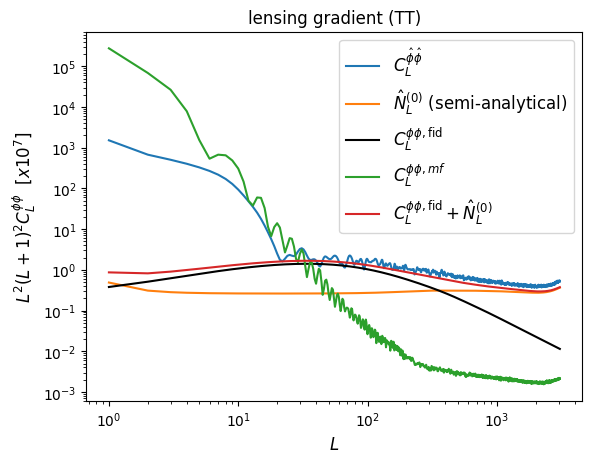

In [3]:
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils

for qe_key in ['ptt', ]:
    # This loads the estimate calculated in the previous cell:
    qlm = parfile.qlms_dd.get_sim_qlm(qe_key, 66)

    # Lensing response according to the fiducial cosmology:
    qresp = parfile.qresp_dd.get_response(qe_key, 'p')
    
    # Estimator normalization is the inverse response:
    qnorm = utils.cli(qresp)
    
    # Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
    nhl = parfile.nhl_dd.get_sim_nhl(-1, qe_key, qe_key)

    # and we plot the normalized resulting spectra:
    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 3072)
    
    pl.figure()
    pl.title('lensing gradient (TT)' if qe_key[0] == 'p' else 'lensing curl (TT)')
    label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
    pl.loglog(ell, hp.alm2cl(qlm-qlm_ptt_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=label)
    pl.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
    pl.loglog(ell, parfile.cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    pl.loglog(ell, hp.alm2cl(qlm_ptt_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=r'$C_L^{\phi\phi, mf}$ ')
    if  qe_key[0] == 'p':
        pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
    pl.xlabel('$L$', fontsize=12)
    pl.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
    pl.legend(fontsize=12, loc='upper right')

In [7]:
for qe_key in ['p_p', ]:
    # Calculate mean-field: (This is time-consuming, but only needs to be done once)
    qlm_p_p_mf = parfile.qlms_dd.get_sim_qlm_mf(qe_key, parfile.mc_sims_mf_dd)

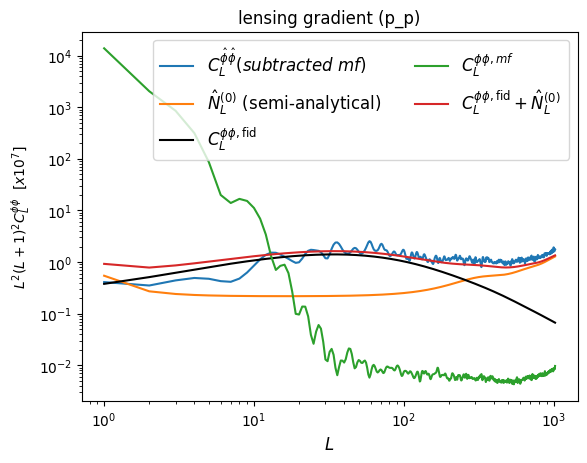

In [8]:
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils


for qe_key in ['p_p',]:
    qresp = parfile.qresp_dd.get_response(qe_key, 'p')
    qnorm = utils.cli(qresp)
    qlm = parfile.qlms_dd.get_sim_qlm(qe_key, 66)

    nhl = parfile.nhl_dd.get_sim_nhl(-1, qe_key, qe_key)

    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 1024)
    
    pl.figure()
    pl.title('lensing gradient (p_p)' if qe_key[0] == 'p' else 'lensing curl (MV)')
    label=r'$C_L^{\hat \phi \hat \phi} (subtracted \ mf)$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega} (subtracted \ mf)$'
    pl.loglog(ell, hp.alm2cl(qlm-qlm_p_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=label)
    pl.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
    pl.loglog(ell, parfile.cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    pl.loglog(ell, hp.alm2cl(qlm_p_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=r'$C_L^{\phi\phi, mf}$ ')
    if  qe_key[0] == 'p':
        pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
    else:
        pl.loglog(ell, (nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\omega\omega, \rm fid} + \hat N_L^{(0)}$ ')

    pl.xlabel('$L$', fontsize=12)
    pl.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]')
    pl.legend(fontsize=12, ncol=2, loc='upper right')

This last cell does the exact same thing for the MV gradient (key 'p') and curl ('x') estimator.

In [2]:
for qe_key in ['p', ]:
    # Calculate mean-field: (This is time-consuming, but only needs to be done once)
    qlm_p_mf = parfile.qlms_dd.get_sim_qlm_mf(qe_key, parfile.mc_sims_mf_dd)

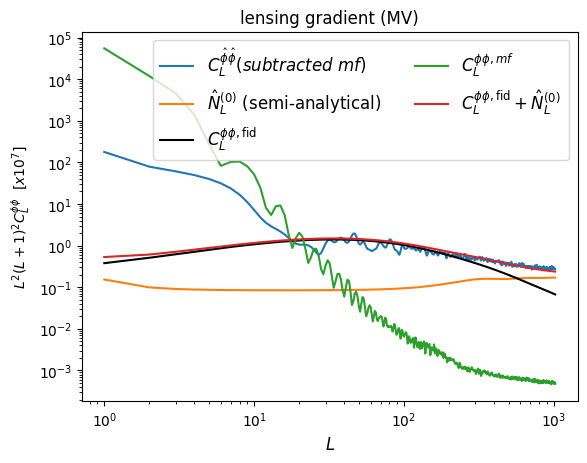

In [4]:
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils


for qe_key in ['p',]:
    qresp = parfile.qresp_dd.get_response(qe_key, 'p')
    qnorm = utils.cli(qresp)
    qlm = parfile.qlms_dd.get_sim_qlm(qe_key, 68)
    #qlm = hp.read_alm('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/rec_qlm/rec_alm_21.fits')
    nhl = parfile.nhl_dd.get_sim_nhl(-1, qe_key, qe_key)

    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 1024)
    
    pl.figure()
    pl.title('lensing gradient (MV)' if qe_key[0] == 'p' else 'lensing curl (MV)')
    label=r'$C_L^{\hat \phi \hat \phi} (subtracted \ mf)$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega} (subtracted \ mf)$'
    pl.loglog(ell, hp.alm2cl(qlm-qlm_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=label)
    pl.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
    pl.loglog(ell, parfile.cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    pl.loglog(ell, hp.alm2cl(qlm_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=r'$C_L^{\phi\phi, mf}$ ')
    if  qe_key[0] == 'p':
        pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
    else:
        pl.loglog(ell, (nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\omega\omega, \rm fid} + \hat N_L^{(0)}$ ')

    pl.xlabel('$L$', fontsize=12)
    pl.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]')
    pl.legend(fontsize=12, ncol=2, loc='upper right')

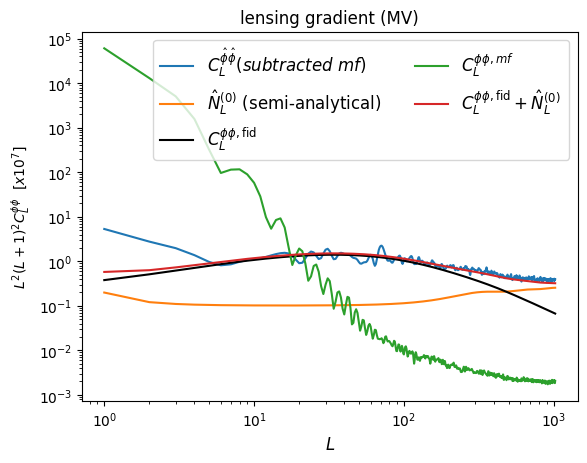

In [22]:
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils


for qe_key in ['p',]:
    qresp = parfile.qresp_dd.get_response(qe_key, 'p')
    qnorm = utils.cli(qresp)
    #qlm = parfile.qlms_dd.get_sim_qlm(qe_key, 21)
    qlm = hp.read_alm('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/rec_qlm/rec_alm_5.fits')
    nhl = parfile.nhl_dd.get_sim_nhl(-1, qe_key, qe_key)

    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 1024)
    
    pl.figure()
    pl.title('lensing gradient (MV)' if qe_key[0] == 'p' else 'lensing curl (MV)')
    label=r'$C_L^{\hat \phi \hat \phi} (subtracted \ mf)$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega} (subtracted \ mf)$'
    pl.loglog(ell, hp.alm2cl(qlm)[ell] / parfile.qlms_dd.fsky12 * w(ell), label=label)
    pl.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
    pl.loglog(ell, parfile.cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    pl.loglog(ell, hp.alm2cl(qlm_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=r'$C_L^{\phi\phi, mf}$ ')
    if  qe_key[0] == 'p':
        pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
    else:
        pl.loglog(ell, (nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\omega\omega, \rm fid} + \hat N_L^{(0)}$ ')

    pl.xlabel('$L$', fontsize=12)
    pl.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]')
    pl.legend(fontsize=12, ncol=2, loc='upper right')

In [24]:
#145和93重建效果几乎完全一致，因此仅用145来delensing
wiener1 = np.loadtxt("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/wiener.dat")  # L, NL, CL+NL
wiener2 = np.loadtxt("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/wiener.dat")  # L, NL, CL+NL

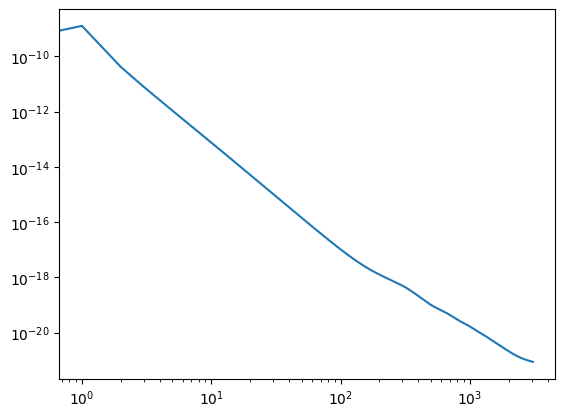

In [31]:
#pl.loglog(wiener1[0], wiener1[1], label='Wiener filter 1')
#pl.loglog(wiener1[0], wiener2[1], label='Wiener filter 2')
pl.loglog(wiener1[0], -wiener1[1]+wiener2[1], label='Wiener filter 2')

(0.001, 100000.0)

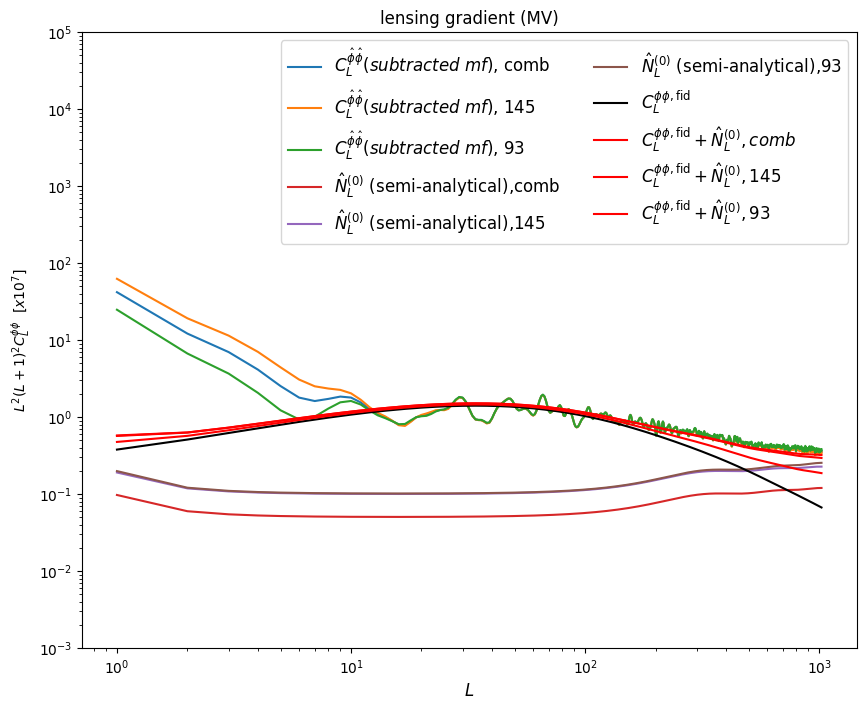

In [28]:
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils

for qe_key in ['p',]:
    qresp = parfile.qresp_dd.get_response(qe_key, 'p')
    qnorm = utils.cli(qresp)
    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 1024)
    
qlm = hp.read_alm("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/com_rec/rec_qlm_22.fits")
qlm1 = hp.read_alm('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/rec_qlm/rec_alm_22.fits')
qlm2 = hp.read_alm('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/rec_qlm/rec_alm_22.fits')

nhl = np.loadtxt("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/nlpp_com.dat")[1] 
nhl1 = np.loadtxt("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/wiener.dat")[1]
nhl2 = np.loadtxt("/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/wiener.dat")[1]

pl.figure(figsize=(10,8))
pl.title('lensing gradient (MV)' if qe_key[0] == 'p' else 'lensing curl (MV)')
label=r'$C_L^{\hat \phi \hat \phi} (subtracted \ mf)$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega} (subtracted \ mf)$'

pl.loglog(ell, hp.alm2cl(qlm)[ell]  / parfile.qlms_dd.fsky12 * w(ell), label=f'{label}, comb')
pl.loglog(ell, hp.alm2cl(qlm1)[ell] / parfile.qlms_dd.fsky12 * w(ell), label=f'{label}, 145')
pl.loglog(ell, hp.alm2cl(qlm2)[ell] / parfile.qlms_dd.fsky12 * w(ell), label=f'{label}, 93')

pl.loglog(ell, nhl[ell]  * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical),comb')
pl.loglog(ell, nhl1[ell] * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical),145')
pl.loglog(ell, nhl2[ell] * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical),93')


pl.loglog(ell, parfile.cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
#pl.loglog(ell, hp.alm2cl(qlm_p_mf)[ell] * qnorm[ell] ** 2 / parfile.qlms_dd.fsky12 * w(ell), label=r'$C_L^{\phi\phi, mf}$ ')
if  qe_key[0] == 'p':
    pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl[ell] ) *  w(ell), "r",label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)},comb$ ')
    pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl1[ell] ) *  w(ell), "r",label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)},145$ ')
    pl.loglog(ell, (parfile.cl_unl['pp'][ell] + nhl2[ell] ) *  w(ell), "r",label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)},93$ ')
else:
    pl.loglog(ell, (nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\omega\omega, \rm fid} + \hat N_L^{(0)}$ ')

pl.xlabel('$L$', fontsize=12)
pl.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]')
pl.legend(fontsize=12, ncol=2, loc='upper right')
pl.ylim(1e-3,1e5)

In [38]:
noise_93 = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons2/test/ALILENS/sims/noise/map_noise_nside2048_0100.fits')
noise_145 = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/test/ALILENS/sims/noise/map_noise_nside2048_0100.fits')

In [39]:
cltt1= hp.anafast(noise_93)
cltt2= hp.anafast(noise_145)

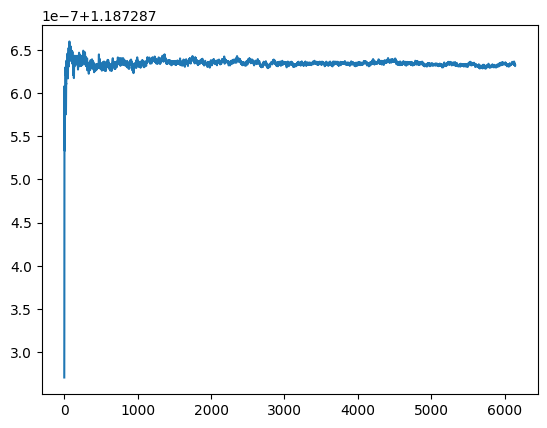

In [44]:
#pl.plot(cltt1)
pl.plot(cltt2/cltt1)
pl.ylim

In [12]:
q2k = lambda l : l * (l + 1) / 2
lmax = parfile.qlms_dd.get_lmax_qlm('p')

pmap_input = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/test/ALILENS/sims/cmbs/map_P_2048_0200.fits')
pmap_rec = hp.alm2map(hp.almxfl(qlm, utils.cli(qresp) ),nside=2048)  

mask = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction/mask/masks/AliCPT_20uKcut150_C_2048.fits')

In [ ]:
#通过截取l范围可知，重建得到的phi在l=8到l=100左右的范围内是相对准确的，这与SNR或者功率谱的计算结果是一致的
sys.path.append('/sharefs/alicpt/users/chenwz/Testarea/FORECAST/Foreground/run_with_foreground')
import curvedsky
def map_cut(nside,map,lcut,lmax=None):
    if lmax == None:
        lmax = 3*nside-1
    blm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,map)
    map_cut = curvedsky.utils.hp_alm2map(nside,lcut,lcut,blm[:lcut+1,:lcut+1])
    return map_cut
llow = 10
lcut = 200
nside=2048

pmap_rec_cut = map_cut(nside,pmap_rec,lcut,lmax=None) - map_cut(nside,pmap_rec,llow,lmax=None)
pmap_input_cut = map_cut(nside,pmap_input,lcut,lmax=None) - map_cut(nside,pmap_input,llow,lmax=None)

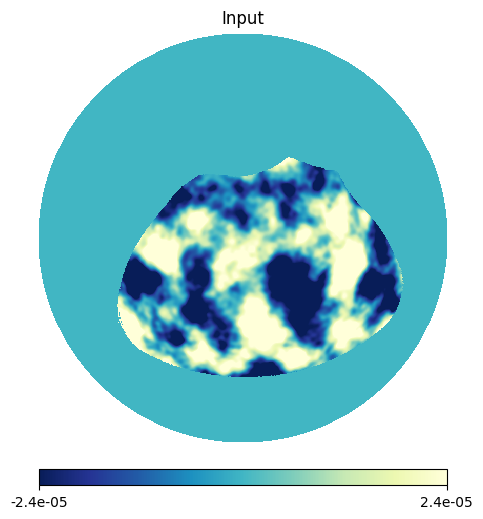

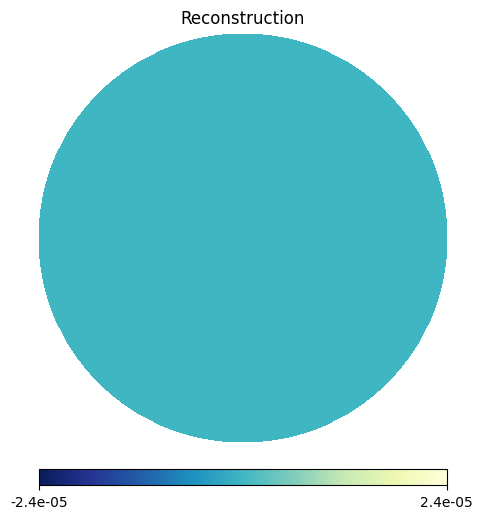

In [12]:
hp.orthview(pmap_input_cut * mask, title='Input', half_sky=True, rot=[180,60], cmap='YlGnBu_r', min=-0.000024, max=0.000024)   
hp.orthview(pmap_rec_cut * mask, title='Reconstruction', half_sky=True, rot=[180,60], cmap='YlGnBu_r', min=-0.000024, max=0.000024)

In [9]:
###################

In [6]:
q2k = lambda l : l * (l + 1) / 2
lmax = parfile.qlms_dd.get_lmax_qlm('p')

pmap_input = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/test/ALILENS/sims/cmbs/map_P_2048_0198.fits')
pmap_rec = hp.alm2map(hp.almxfl(qlm-qlm_p_mf, utils.cli(qresp) ),nside=2048)  
#pmap_mf = hp.alm2map(hp.almxfl(qlm_p_mf, utils.cli(qresp) ),nside=2048) 

mask = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction/mask/masks/AliCPT_20uKcut150_C_2048.fits')

In [6]:
#hp.write_map('/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/pmap_rec_2048_Simons_93.fits', pmap_rec)

In [7]:
#通过截取l范围可知，重建得到的phi在l=8到l=100左右的范围内是相对准确的，这与SNR或者功率谱的计算结果是一致的
sys.path.append('/sharefs/alicpt/users/chenwz/Testarea/FORECAST/Foreground/run_with_foreground')
import curvedsky
def map_cut(nside,map,lcut,lmax=None):
    if lmax == None:
        lmax = 3*nside-1
    blm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,map)
    map_cut = curvedsky.utils.hp_alm2map(nside,lcut,lcut,blm[:lcut+1,:lcut+1])
    return map_cut
llow = 10
lcut = 200
nside=2048

pmap_rec_cut = map_cut(nside,pmap_rec,lcut,lmax=None) - map_cut(nside,pmap_rec,llow,lmax=None)
pmap_input_cut = map_cut(nside,pmap_input,lcut,lmax=None) - map_cut(nside,pmap_input,llow,lmax=None)
#pmap_mf_cut = map_cut(nside,pmap_mf,lcut,lmax=None) - map_cut(nside,pmap_mf,llow,lmax=None)

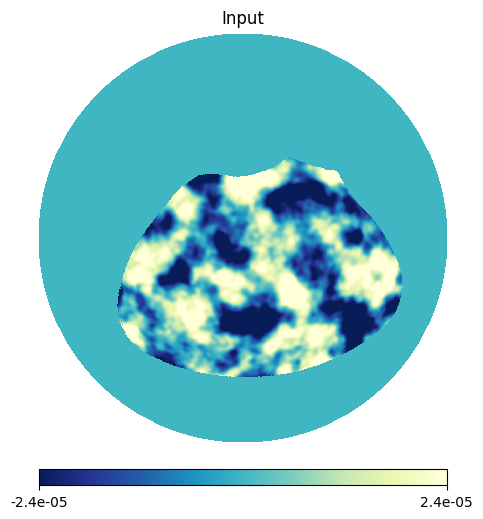

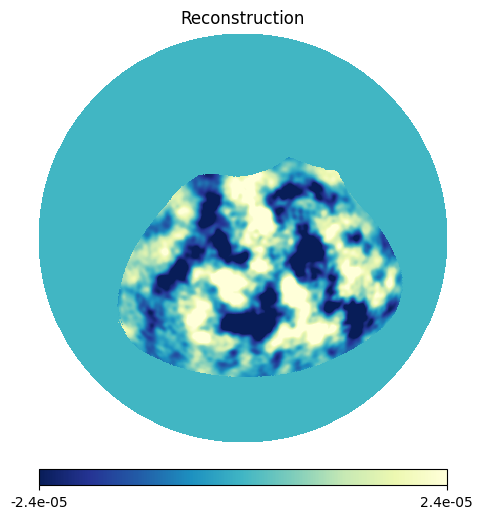

In [8]:
hp.orthview(pmap_input_cut * mask, title='Input', half_sky=True, rot=[180,60], cmap='YlGnBu_r', min=-0.000024, max=0.000024)   
hp.orthview(pmap_rec_cut * mask, title='Reconstruction', half_sky=True, rot=[180,60], cmap='YlGnBu_r', min=-0.000024, max=0.000024)
#hp.orthview(pmap_mf_cut * mask, title='Mean-field', half_sky=True, rot=[180,60], cmap='YlGnBu_r', min=-0.000024, max=0.000024)